In [1]:
#Import libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import PIL as pil
import os
import PIL
import pathlib
import glob
from tensorflow.keras.layers import *
from tensorflow.keras.models import *


#Set to GPU
devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(devices[0], True)

#Path
images_source = pathlib.Path("D:\s4532664\COMP3710\ISIC2018_Task1-2_Training_Data")

#Input images
input_dir = images_source / "ISIC2018_Task1-2_Training_Input_x2\*.jpg"

#Segmentation images (label images)
seg_dir = images_source / "ISIC2018_Task1_Training_GroundTruth_x2\*.png"
                             
#Setup arrays for training, testing and validation datasets
X_train = None
X_test = None
X_valid = None
y_train = None
y_test = None
y_valid = None

training = None
validation = None
testing = None

In [2]:
print(input_dir)
print(seg_dir)

D:\s4532664\COMP3710\ISIC2018_Task1-2_Training_Data\ISIC2018_Task1-2_Training_Input_x2\*.jpg
D:\s4532664\COMP3710\ISIC2018_Task1-2_Training_Data\ISIC2018_Task1_Training_GroundTruth_x2\*.png


In [3]:
#Process every filename in the array as an image, using TF functions. 
#Normalise every image by either 0 or 1 and divide it by 255 for scaling purposes

def convert_file_image(input_file, seg_file):
    input_image = tf.cast(tf.image.resize(tf.image.convert_image_dtype(tf.image.decode_jpeg(tf.io.read_file(input_file),\
                                                                                        channels=3), tf.uint8), (512, 384)), \
                      tf.float32) / 255.0
    seg_image = tf.cast(tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(input_file), channels=3), (512, 384)),  \
                      tf.float32) / 255.0        
    return input_image, seg_image

In [4]:
#Load images from disk into training, testing and validation arrays (DO DOCSTRING)
def load_data(xtrain, xtest, xvalid, ytrain, ytest, yvalid, inputdir, segdir):
    
    xtrain = sorted(glob.glob(str(inputdir)))
    ytrain = sorted(glob.glob(str(segdir)))
    
    #Split the images into 3 datasets (Training - 50%, Validation - 25%, Testing - 25%)
    
    half_length = int(len(xtrain)/2)
    quarter_length_ceil = int(tf.math.ceil(len(xtrain)/4))
    print(quarter_length_ceil)
    
    xtest = xtrain[-(quarter_length_ceil-1):]
    xvalid = xtrain[half_length:half_length + quarter_length_ceil]
    xtrain = xtrain[0:half_length]
    
    ytest = ytrain[-(quarter_length_ceil-1):]
    yvalid = ytrain[half_length:half_length + quarter_length_ceil]
    ytrain = ytrain[0:half_length]
     
    traindata = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
    validdata = tf.data.Dataset.from_tensor_slices((xvalid, yvalid))
    testdata = tf.data.Dataset.from_tensor_slices((xtest, ytest))
    
    traindata = traindata.map(convert_file_image)
    validdata = validdata.map(convert_file_image)
    testdata = testdata.map(convert_file_image)
    
    return traindata, validdata, testdata

In [5]:
training, validation, testing = load_data(X_train, X_test, X_valid, y_train, \
                                                         y_test, y_valid, input_dir, seg_dir)

649


In [10]:
def unet_model():
    inputs = Input((512, 384, 3))

    conv2D_1 = Conv2D(32, 3, activation = 'relu', padding = 'same')(inputs)
    conv2D_1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2D_1)
    conv2D_1 = Dropout(0.25)(conv2D_1)
    maxpool2D_1 = MaxPooling2D(pool_size=(2, 2))(conv2D_1)
    maxpool2D_1 = BatchNormalization()(maxpool2D_1)
        
    conv2D_2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(maxpool2D_1)
    conv2D_2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2D_2)
    conv2D_2 = Dropout(0.25)(conv2D_2)
    maxpool2D_2 = MaxPooling2D(pool_size=(2, 2))(conv2D_2)
    maxpool2D_2 = BatchNormalization()(maxpool2D_2)

    conv2D_3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(maxpool2D_2)
    conv2D_3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2D_3)
    conv2D_3 = Dropout(0.25)(conv2D_3)
    maxpool2D_3 = MaxPooling2D(pool_size=(2, 2))(conv2D_3)
    maxpool2D_3 = BatchNormalization()(maxpool2D_3)

    conv2D_4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(maxpool2D_3)
    conv2D_4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2D_4)
    dropout_4 = Dropout(0.5)(conv2D_4)
    maxpool2D_4 = MaxPooling2D(pool_size=(2, 2))(dropout_4)
    maxpool2D_4 = BatchNormalization()(maxpool2D_4)

    conv2D_5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(maxpool2D_4)
    conv2D_5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2D_5)
    dropout_5 = Dropout(0.5)(conv2D_5)
    dropout_5 = BatchNormalization()(dropout_5)

    upsample_6 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(dropout_5))
    concat_6 = concatenate([dropout_4,upsample_6], axis = 3)
    conv2D_6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(concat_6)
    conv2D_6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2D_6)
    conv2D_6 = BatchNormalization()(conv2D_6)

    upsample_7 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv2D_6))
    concat_7 = concatenate([conv2D_3,upsample_7], axis = 3)
    conv2D_7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(concat_7)
    conv2D_7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2D_7)
    conv2D_7 = BatchNormalization()(conv2D_7)

    upsample_8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv2D_7))
    concat_8 = concatenate([conv2D_2,upsample_8], axis = 3)
    conv2D_8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(concat_8)
    conv2D_8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2D_8)
    conv2D_8 = BatchNormalization()(conv2D_8)

    upsample_9 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv2D_8))
    concat_9 = concatenate([conv2D_1,upsample_9], axis = 3)
    conv2D_9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(concat_9)
    conv2D_9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2D_9)
    conv2D_9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2D_9)
    conv2D_9 = BatchNormalization()(conv2D_9)

    conv2D_10 = Conv2D(3, 1, activation = 'softmax')(conv2D_9)

    model = tf.keras.Model(inputs=inputs, outputs=conv2D_10)

    opt = tf.keras.optimizers.Adam(lr=0.001)

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [11]:
model = unet_model()

results = model.fit(x=training.batch(1), epochs = 2, validation_data = validation.batch(1))

Train for 1297 steps, validate for 649 steps
Epoch 1/2
1297/1297 [==============================] - 101s 78ms/step - loss: 0.8337 - accuracy: 0.0022 - val_loss: 0.8022 - val_accuracy: 1.0760e-05
Epoch 2/2
1297/1297 [==============================] - 95s 73ms/step - loss: 0.8332 - accuracy: 0.0022 - val_loss: 0.8022 - val_accuracy: 1.0760e-05


648/648 [==============================] - 35s 54ms/step - loss: 0.7980 - accuracy: 8.7811e-04


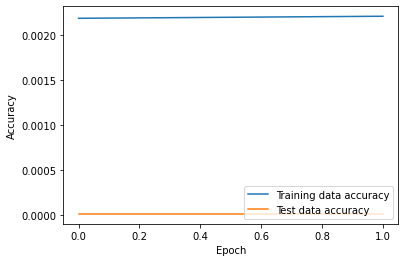

In [12]:
plt.plot(results.history['accuracy'], label='Training data accuracy')
plt.plot(results.history['val_accuracy'], label = 'Test data accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x=testing.batch(1))